Adaptacion de modelo tomado de https://apmonitor.com/dde/index.php/Main/LLMTransformers con datos de Shanghai

In [47]:
#Carguemos los datos
import pandas as pd
ShanghaiDat=pd.read_csv('Shanghai-2005-2025.csv')
ShanghaiDat=ShanghaiDat.drop(ShanghaiDat.columns[0], axis=1) #Eliminar la primera columna que tiene la etiqueta

print('Dimension del dataframe:',ShanghaiDat.shape)
print('Primer elemento del dataframe:',ShanghaiDat.iloc[0,0])

Dimension del dataframe: (1, 4875)
Primer elemento del dataframe: 1242.7740478515625


In [48]:
#Nos saltamos la parte del codigo que genera datos porque nosotros ya tenemos datos reales
#Debemos convertir nuestros datos en una ventana de datos deslizantes. Esto es, obtener una matriz dividiendo los datos en epocas de 10 dias y obtener los target para cada una de esas epocas
import numpy as np

# Convertimos los datos a un array de 1 dimension
ShanghaiDat = np.array(ShanghaiDat).flatten()

#Dividimos en epocas de 10 dias
def Epocas(sequence_length=10):
    size = len(ShanghaiDat) 
    sequences = [ShanghaiDat[i:i+sequence_length] for i in range(size-sequence_length)]
    next_points = ShanghaiDat[sequence_length:]

    # Convertir a NumPy arrays correctamente
    return np.array(sequences), np.array(next_points)

Shanghai_epocas, Shanghai_targets = Epocas()

print('Shape de Shanghai_epocas:', Shanghai_epocas.shape)
print('Shape de Shanghai_targets:', Shanghai_targets.shape)

#Ahora tenemos 4865 epocas de 10 dias en una variable, y en la otra varibale todos los targets de cada epoca. Es importante señalar que ninguna epoca puede contener a su target
#Es por ello que en la ultima epoca solo se llega al penultimo valor
print(Shanghai_epocas[-1])

Shape de Shanghai_epocas: (4865, 10)
Shape de Shanghai_targets: (4865,)
[3236.03198242 3241.82104492 3244.37792969 3242.62304688 3213.62402344
 3230.1640625  3252.62597656 3250.60107422 3229.48803711 3270.65893555]


In [49]:
#Despues necesitamos definir una clase que permita tratar los datos para poder usar DataLoader de pytorch.
#Terminamos de cargar todas las librerias que vamos a usar
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset): #Heredamos caracteristicas de Dataset
    def __init__(self, sequences, next_points): #Determina que parametros debemos pasar al crear una instancia
        self.sequences = sequences
        self.next_points = next_points

    def __len__(self): #Nos dice la longitud de nuestros datos de secuancia
        return len(self.sequences)

    def __getitem__(self, idx): #Nos da cualquier epoca que queramos y su target asociado
        return self.sequences[idx], self.next_points[idx]

In [50]:
#Probamos crear una instancia con nuestros datos
Datos=TimeSeriesDataset(Shanghai_epocas, Shanghai_targets)
print(len(Datos))
Datos[-1]

4865


(array([3236.03198242, 3241.82104492, 3244.37792969, 3242.62304688,
        3213.62402344, 3230.1640625 , 3252.62597656, 3250.60107422,
        3229.48803711, 3270.65893555]),
 np.float64(3303.6669921875))

In [51]:
# Transformer Model (simplified for numerical data)
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, sequence_length=10, num_layers=1, num_heads=2, dim_feedforward=512): #Se definen los parametros del modelo. Una capa, 2 cabezas de atencion
        super(TransformerModel, self).__init__() #Llama al init de la clase padre, que es el constructor del modelo. Es necesario para crear modelos personalizados
        self.sequence_length = sequence_length
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size*sequence_length, nhead=num_heads, dim_feedforward=dim_feedforward) #Define una capa
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers) #Crea el transformer definido anteriormente
        self.fc_out = nn.Linear(input_size * sequence_length, 1) #Capa fully connected que toma la salida del trandormer (10 valores) y regresa un unico valor (prediccion, next point)

    
    #Aqui se define como fluye la informacion a traves del modelo. Pasar datos por la red y obtener predicciones
    def forward(self, src): #src es el tensor de entrada
        # Reshape to match the input dimensions
        src = src.reshape(-1, self.sequence_length, 1)  #-1 hace que se ajuste automaticamente el tamaño del batch
        src = src.flatten(start_dim=1) #Aplana la dimension 1D
        src = src.unsqueeze(0)  # Add batch dimension *
        out = self.transformer_encoder(src) #Aplica el modelo en la secuencia
        out = out.squeeze(0)  # Remove batch dimension *
        return self.fc_out(out) #Le aplica la capa de salida

In [52]:
# Preparamos los datos
sequences, next_points = Epocas() #Cargamos nuestras epocas de 10 dias(Shanghai_epocas) y nuestros target (Shanghai_targets)
dataset = TimeSeriesDataset(sequences, next_points) #Asignamos las funciones a nuestros datos para poder manipularlos
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) #Divide los datos en batches y los revuelve

In [53]:
#Entrenamiento del modelo
model = TransformerModel() #Se llama al modelo definido
criterion = nn.MSELoss() #Funcion de perdida
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #Optimizador

# Training loop
losses=[]
for epoch in range(300):  # Numero de epocas, esto es numero de veces que todos los datos pasan por el modelo
    for seq, next_point in dataloader: #Itera a traves de los batches
        seq, next_point = seq.float(), next_point.float().unsqueeze(1) #Pone los datos en forma decimal 
        output = model(seq) #Se pasan las secuencias al modelo para obtener la prediccion output
        loss = criterion(output, next_point) #Se calcula la perdida 
        optimizer.zero_grad() #Se limpian los gredientes de la iteracion anterior
        loss.backward() #Back propagation. Gradientes de la perdida con respecto a los pesos y bias
        optimizer.step() #Actualiza los parametros del modelo con base en los gradientes
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    losses.append(loss)

C:\Users\Antonio Rojas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 9292322.0
Epoch 2, Loss: 4105259.75
Epoch 3, Loss: 4195604.0
Epoch 4, Loss: 5762035.5
Epoch 5, Loss: 5749176.0
Epoch 6, Loss: 5184022.0
Epoch 7, Loss: 9824968.0
Epoch 8, Loss: 1587398.25
Epoch 9, Loss: 7069974.5
Epoch 10, Loss: 7474377.0
Epoch 11, Loss: 9502316.0
Epoch 12, Loss: 10222776.0
Epoch 13, Loss: 12834849.0
Epoch 14, Loss: 7390749.5
Epoch 15, Loss: 4983319.5
Epoch 16, Loss: 9804286.0
Epoch 17, Loss: 2406377.75
Epoch 18, Loss: 13911155.0
Epoch 19, Loss: 3525333.5
Epoch 20, Loss: 8494548.0
Epoch 21, Loss: 1108220.375
Epoch 22, Loss: 20834202.0
Epoch 23, Loss: 5973722.0
Epoch 24, Loss: 6158144.0
Epoch 25, Loss: 9865337.0
Epoch 26, Loss: 23593674.0
Epoch 27, Loss: 14335432.0
Epoch 28, Loss: 7365690.0
Epoch 29, Loss: 9856410.0
Epoch 30, Loss: 10792574.0
Epoch 31, Loss: 9273500.0
Epoch 32, Loss: 13622274.0
Epoch 33, Loss: 4081128.0
Epoch 34, Loss: 9962611.0
Epoch 35, Loss: 6776426.5
Epoch 36, Loss: 1793392.75
Epoch 37, Loss: 5799221.0
Epoch 38, Loss: 6725069.5
Epoch 3

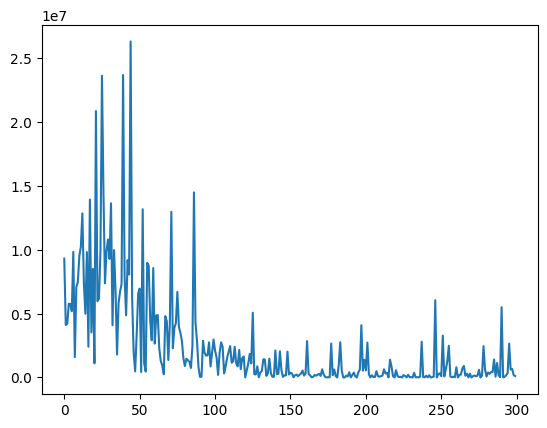

In [54]:
import matplotlib.pyplot as plt
# Desconectar cada loss individualmente
losses = [loss.detach().cpu().item() for loss in losses]

# Ahora puedes convertirlo a array
losses = np.array(losses)

plt.plot(losses)
plt.show()

In [69]:
#Veamos como predice el modelo
test_seq = torch.tensor(sequences[1]).float()
test_seq = test_seq.unsqueeze(0)  #Añades una dimensión de batch aquí
with torch.no_grad():
    predicted_point = model(test_seq)
print('Valores usados para la prediccion:',sequences[0])
print("Prediccion(dato siguiente):", predicted_point.item())
print('Dato siguiente real:',next_points[0])


Valores usados para la prediccion: [1242.77404785 1251.93701172 1239.43005371 1244.74597168 1252.40100098
 1257.46203613 1256.92297363 1256.31396484 1245.61999512 1216.65197754]
Prediccion(dato siguiente): 2851.34375
Dato siguiente real: 1225.4539794921875


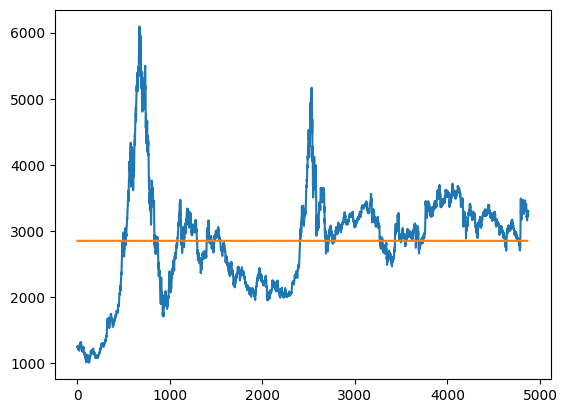

[2851.470458984375, 2850.596435546875, 2851.253662109375, 2851.44287109375, 2851.48681640625, 2851.427490234375, 2850.406494140625, 2851.485107421875, 2851.50146484375, 2851.25, 2851.11181640625, 2850.22119140625, 2850.865966796875, 2851.096923828125, 2851.51171875, 2851.48876953125, 2851.1787109375, 2851.241455078125, 2851.142578125, 2850.7880859375, 2850.37890625, 2851.0908203125, 2851.483642578125, 2850.885498046875, 2851.48583984375, 2851.246337890625, 2851.486328125, 2850.712646484375, 2851.225341796875, 2851.3720703125, 2851.48876953125, 2849.402099609375, 2851.52490234375, 2850.635498046875, 2851.486083984375, 2851.263427734375, 2851.054443359375, 2851.011474609375, 2850.06787109375, 2851.32177734375, 2851.361083984375, 2851.2041015625, 2851.2099609375, 2851.519287109375, 2851.214599609375, 2851.505126953125, 2850.773193359375, 2851.486572265625, 2851.271728515625, 2850.900390625, 2850.921875, 2851.023681640625, 2851.085693359375, 2851.42333984375, 2851.496826171875, 2851.409179

In [56]:
#Comparemos los datos reales con las predicciones que hace el modelo con los mismos
predicciones=[]
for i in sequences:
    test_seq = torch.tensor(i).float()
    test_seq = test_seq.unsqueeze(0)
    with torch.no_grad():
        predicted_point = model(test_seq)
    predicciones.append(predicted_point.item())


plt.plot(ShanghaiDat)
plt.plot(predicciones)
plt.show()
print(predicciones)